# Differentiable programming for particle physics simulations
#### Roland Grinis - researcher at MIPT Nuclear Physics Methods lab, CTO at GrinisRIT (grinisrit.com)

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

Keep an eye on `KMath` [github.com/mipt-npm/kmath](https://github.com/mipt-npm/kmath) - Maths library in `Kotlin` (thanks to JetBrains Research for support)

## Introduction
In this workshop we will explore the challenges and opportunities that arise in integrating `automatic differentiation (AD)` platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful `AD` engines such as [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/). Since then, those technologies grew up into full-fledged `differentiable programming (DP)` frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between `DP`, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. See for example the package [torchdiffeq](https://github.com/rtqichen/torchdiffeq) and [diffeqflux](https://diffeqflux.sciml.ai/dev/) developed respectively by:

* R. Chen et al., *Neural ordinary differential equations*, Advances in Neural Information Processing Systems (2018)
* C. Rackauckus et al., *Universal differential equations for scientific machine learning*, arXiv preprint arXiv:2001.04385 (2020)

On one hand, we obtain a more flexible and data-driven approach to mathematical modelling that opens the door to solving applied problems that we couldn't tackle before. On the other hand, many techniques such that the `adjoint sensitivity methods` gave rise to whole new powerful algorithms for `AD`.

In particle physics simulations, we have a similar picture which is almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the `Backward Monte-Carlo` techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples.

In [8]:
import torch
import torch.autograd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

## Backward Monte-Carlo 

This Monte-Carlo technique seeks to reverse the simulation from a given final state up to a distribution of initial states. Several implementation have been considered, see for example:

* L. Desorgher et al., *Implementation of the reverse/adjoint Monte Carlo method into Geant4*, Nucl. Instrum. Meth. (2010)
* V. Niess et al., *Backward Monte-Carlo applied to muon transport*, Comput. Phys. Comm. (2018)

The latter is backed by a dedicated `C99` muon transport library, [PUMAS](https://github.com/niess/pumas). In fact, this situation arises naturally in `muography`:

<img src="muography.png" />

Image credits: Z. X. Zhang et al., *Muography and Its Potential Applications to Mining and Rock Engineering*, Rock Mechanics and Rock Engineering 53, 4893-4907, (2020)

Describe the algorithm concisely (specifically biasing).

In [ ]:
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)

In [7]:
def level_set(t, node, x):
    zz02 = (-node[2] * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

def plot_detector(detector, node_param, x = torch.linspace(-5., 5., 500)):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])

In [ ]:
knode = torch.tensor([0.,5., 10.])


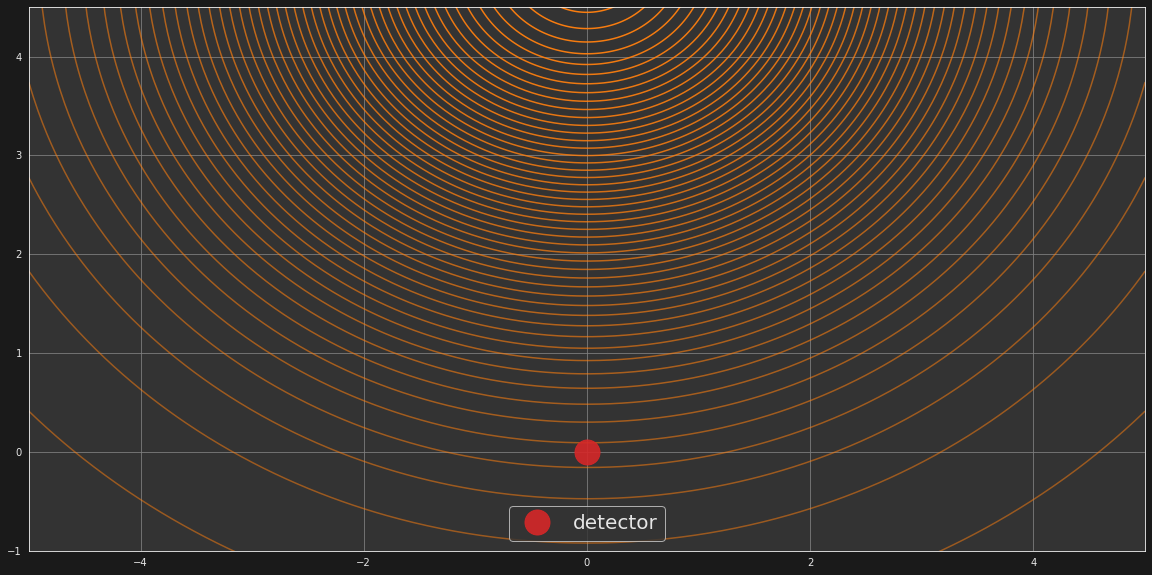

In [13]:

plot_detector(knode)

In [ ]:
material_A = 0.01
material_B = 0.9
thetas = torch.tensor([0.1,0.0, -0.08]) * np.pi

In [14]:
def mix_density(state, node):
    return torch.exp(-(state - node[:2]).pow(2).sum(1) / node[2].abs())

In [15]:
def rot(theta):
    n = theta.numel()
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([c,-s, s, c]).T.reshape((n,2,2))

In [16]:
def backward_mc(theta, node, npar):
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.reshape((npar, 2,1))).squeeze()
    state1 = detector + step1

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state1, node)
    weights = torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * np.pi * (torch.rand(npar) - 0.5))
    step2 = length2.reshape((npar,1)) * step1 / length1.reshape((npar,1))
    step2 = rot2.matmul(step2.reshape((npar,2,1))).squeeze()
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state2, node)
    weights *= torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    return weights, [state1, state2]

In [17]:
bmcs = []
for theta in thetas:
    _, bmc = backward_mc(theta, knode, 10)
    bmcs.append(torch.stack(bmc).transpose(0,1))

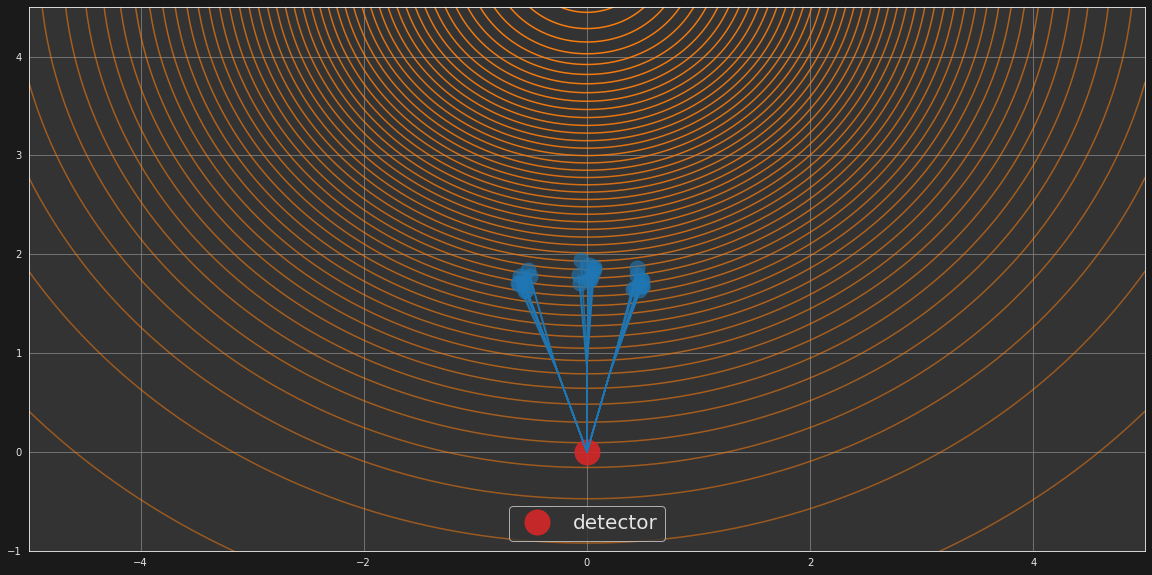

In [18]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, node_param):
    plot_detector(node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

plot_bmc(bmcs, knode)

In [20]:
for theta in thetas:
    print(f'Flux at {round(theta.item(),2)}: {backward_mc(theta, knode, 100000)[0].mean()}')

Flux at 0.31: 0.5603850483894348
Flux at 0.0: 0.5343799591064453
Flux at -0.25: 0.5553991198539734


In [21]:
observed_flux = torch.tensor([0.54, 0.57, 0.62])

In [22]:
def log_prob_flux(node_params):
    log_prob = torch.tensor(0.)
    for i in range(len(thetas)):
        log_prob += (observed_flux[i] - backward_mc(thetas[i], node_params, 100000)[0].mean()).pow(2) / 0.01
    return - log_prob

In [24]:
knodeg = knode.clone().requires_grad_()
pflux = - log_prob_flux(knodeg)
dpflux = torch.autograd.grad(outputs=pflux, inputs=knodeg)[0]
dpflux

tensor([ 0.5965, -3.8344,  0.6793])

In [17]:
knodeg = knode.clone()
hess = torch.autograd.functional.hessian(log_prob_flux, knodeg)
hess

tensor([[  0.6597,  -0.0582,   0.0770],
        [ -0.0582, -48.6436,   8.5588],
        [  0.0770,   8.5588,  -1.4726]])

In [26]:
def eval_gradient(node_params):
    nodeg = node_params.detach().requires_grad_()
    pflux = - log_prob_flux(nodeg)
    dpflux = torch.autograd.grad(outputs=pflux, inputs=nodeg)[0]
    return dpflux

In [27]:
nu = 0.05
N = 501
gdescent = torch.zeros(N) 

In [28]:
inode = torch.tensor([5.,15.,10.]) 
new_knode = inode - nu * eval_gradient(inode)  
res = []
for i in range(N):
    g = eval_gradient(new_knode)
    new_knode -= nu * g / (g.norm() + 1e-6)
    gdescent[i] = - log_prob_flux(new_knode)
    if i % 50 == 0:
        print(f'log probability : {gdescent[i]}')
        print(f'node {i} : {new_knode}')
    if i > (N-100):
        res.append(new_knode.detach().clone())

log probability : 56.72943878173828
node 0 : tensor([ 4.9906, 14.9747, 10.0192])
log probability : 58.360740661621094
node 50 : tensor([ 4.3005, 13.1068, 11.2582])
log probability : 57.52143096923828
node 100 : tensor([ 3.5163, 10.9900, 12.3287])
log probability : 53.73283767700195
node 150 : tensor([ 2.6963,  8.7794, 13.1569])
log probability : 15.81270980834961
node 200 : tensor([ 1.8467,  6.5068, 13.7559])
log probability : 0.516560435295105
node 250 : tensor([ 0.4324,  5.7238, 14.0055])
log probability : 0.1818051040172577
node 300 : tensor([-0.7314,  5.7321, 14.0074])
log probability : 0.042920902371406555
node 350 : tensor([-1.3548,  5.5812, 13.9910])
log probability : 0.013790939934551716
node 400 : tensor([-1.6296,  5.4868, 13.9786])
log probability : 0.014055837877094746
node 450 : tensor([-1.8025,  5.4221, 13.9690])
log probability : 0.018504353240132332
node 500 : tensor([-1.8895,  5.3800, 13.9657])


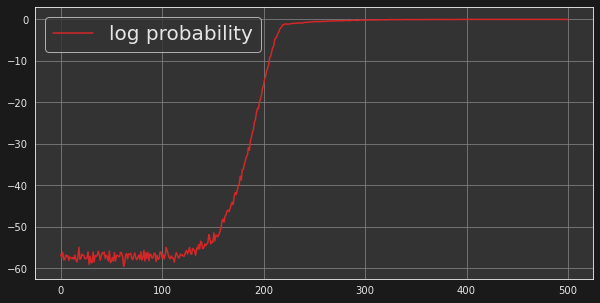

In [29]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(N), -gdescent.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

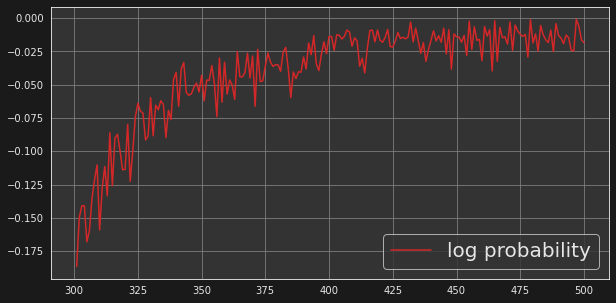

In [30]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(N)[-200:], -gdescent.numpy()[-200:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [31]:
optimal_node = torch.stack(res[-50:]).mean(0)
optimal_node

tensor([-1.8430,  5.3751, 13.9707])

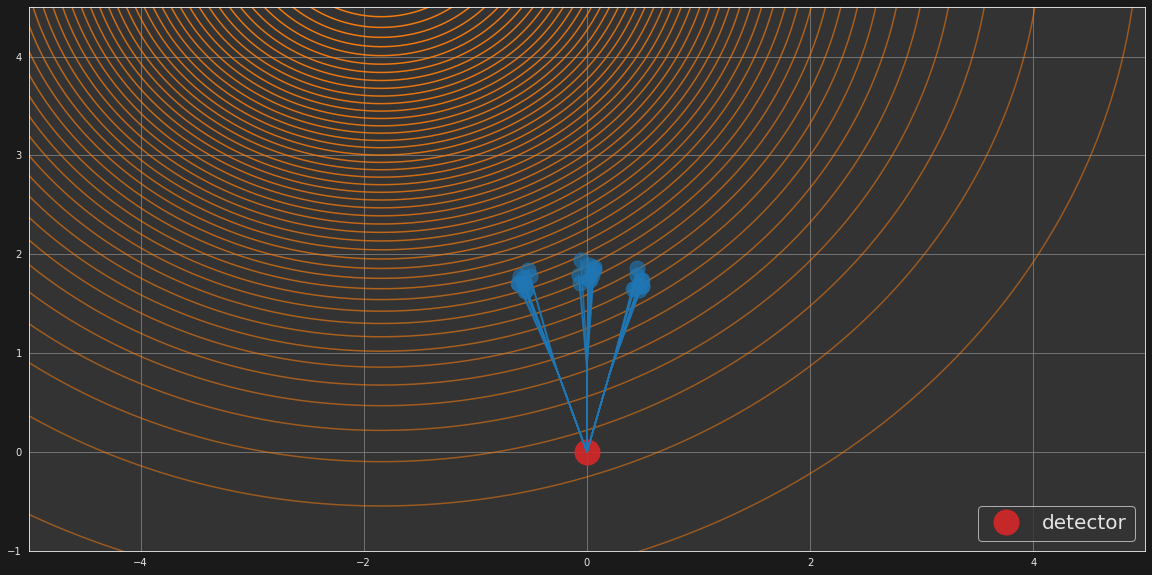

In [32]:
plot_bmc(bmcs, optimal_node)